In [30]:
import json
import pandas as pd
from pathlib import Path

# set up path
DATA_DIR = Path("../data/raw")

EVENT_DIR = DATA_DIR / "event_data" / "May 1, 2025"
TRACKING_DIR = DATA_DIR / "tracking_data"

print("EVENT_DIR exists:", EVENT_DIR.exists(), EVENT_DIR)
print("TRACKING_DIR exists:", TRACKING_DIR.exists(), TRACKING_DIR)

# list what we can load
print("Tracking files:", sorted([p.name for p in TRACKING_DIR.glob("*.jsonl.bz2")])[:10])

EVENT_DIR exists: True ../data/raw/event_data/May 1, 2025
TRACKING_DIR exists: True ../data/raw/tracking_data
Tracking files: ['3812.jsonl.bz2', '3813.jsonl.bz2']


In [31]:
import bz2
from pathlib import Path

path = Path("../data/raw/tracking_data/3812.jsonl.bz2")

with bz2.open(path, "rt") as f:
    for i in range(3):
        line = f.readline()
        print(f"\n--- line {i+1} (len={len(line)}) ---\n")
        print(line[:800])  # prints only first 800 chars so it doesn't spam


--- line 1 (len=5246) ---

{"version":"4.1.0","gameRefId":3812.0,"generatedTime":"2024-08-22T21:38:04.474529Z","smoothedTime":"2024-08-28T07:13:57.330569Z","videoTimeMs":141007.674,"frameNum":4226,"period":1,"periodElapsedTime":0.0,"periodGameClockTime":0.0,"homePlayers":[{"jerseyNum":"21","confidence":"HIGH","visibility":"VISIBLE","x":13.975,"y":19.244,"speed":0.179},{"jerseyNum":"4","confidence":"HIGH","visibility":"VISIBLE","x":8.035,"y":6.507,"speed":0.105},{"jerseyNum":"16","confidence":"LOW","visibility":"ESTIMATED","x":41.257,"y":-0.454,"speed":0.574},{"jerseyNum":"6","confidence":"HIGH","visibility":"VISIBLE","x":9.283,"y":-0.842,"speed":0.425},{"jerseyNum":"22","confidence":"HIGH","visibility":"VISIBLE","x":17.438,"y":-22.039,"speed":0.156},{"jerseyNum":"5","confidence":"HIGH","visibility":"VISIBLE","x":6.7

--- line 2 (len=4461) ---

{"version":null,"gameRefId":null,"generatedTime":null,"smoothedTime":null,"videoTimeMs":141041.041,"frameNum":4227,"period":1,"periodElapsedTim

In [32]:
import json, bz2
from pathlib import Path

path = Path("../data/raw/tracking_data/3812.jsonl.bz2")

with bz2.open(path, "rt") as f:
    obj = json.loads(f.readline())

obj.keys()
#Check what we are dealing with

dict_keys(['version', 'gameRefId', 'generatedTime', 'smoothedTime', 'videoTimeMs', 'frameNum', 'period', 'periodElapsedTime', 'periodGameClockTime', 'homePlayers', 'homePlayersSmoothed', 'awayPlayers', 'awayPlayersSmoothed', 'balls', 'ballsSmoothed', 'game_event_id', 'possession_event_id', 'game_event', 'possession_event'])

In [33]:
import bz2, json
import pandas as pd
from pathlib import Path

path = Path("../data/raw/tracking_data/3812.jsonl.bz2")

N = 2000  # start small
rows = []

with bz2.open(path, "rt") as f:
    for _ in range(N):
        rows.append(json.loads(f.readline()))

df_frames = pd.DataFrame(rows)

df_frames.shape, df_frames.columns.tolist()

((2000, 19),
 ['version',
  'gameRefId',
  'generatedTime',
  'smoothedTime',
  'videoTimeMs',
  'frameNum',
  'period',
  'periodElapsedTime',
  'periodGameClockTime',
  'homePlayers',
  'homePlayersSmoothed',
  'awayPlayers',
  'awayPlayersSmoothed',
  'balls',
  'ballsSmoothed',
  'game_event_id',
  'possession_event_id',
  'game_event',
  'possession_event'])

In [34]:
df_frames[["gameRefId", "period", "frameNum", "videoTimeMs"]].head()
df_frames[["game_event_id", "possession_event_id"]].head()
df_frames["videoTimeMs"].describe()

#check frames and how much they actually cover


count      2000.000000
mean     174197.530853
std       19080.897844
min      141007.674000
25%      157682.682500
50%      174357.691000
75%      190532.198750
max      207207.207000
Name: videoTimeMs, dtype: float64

In [35]:
df_frames["game_event_id"].notna().mean(), df_frames["game_event_id"].notna().sum()

(np.float64(0.3905), np.int64(781))

In [36]:
# find first frame with no event id
idx = df_frames["game_event_id"].isna().idxmax()
row = df_frames.loc[idx]

type(row["homePlayers"]), len(row["homePlayers"]), type(row["balls"]), row["balls"]

(list, 11, list, [{'visibility': 'VISIBLE', 'x': -1.58, 'y': 0.5, 'z': 0.0}])

In [37]:
import numpy as np

# 100 ms per frame for 10 fps
bin_ms = 100

df_frames["t_bin_10fps"] = (df_frames["videoTimeMs"] // bin_ms).astype("int64")

# keep the first frame in each 100ms bin
df_10fps = df_frames.drop_duplicates(subset=["t_bin_10fps"]).copy()

df_frames.shape, df_10fps.shape
# how many frames are we dropping?

((2000, 20), (663, 20))

In [38]:
from pathlib import Path

# uses EVENT_DIR you already set earlier
event_files = sorted(EVENT_DIR.glob("*.json"))

len(event_files), event_files[:3]

(64,
 [PosixPath('../data/raw/event_data/May 1, 2025/10502.json'),
  PosixPath('../data/raw/event_data/May 1, 2025/10503.json'),
  PosixPath('../data/raw/event_data/May 1, 2025/10504.json')])

In [39]:
import json
import pandas as pd

# use the event_files list you already made
sample_files = event_files[:10]

shot_counts = []
for path in sample_files:
    with open(path, "r") as f:
        raw = json.load(f)

    df = pd.json_normalize(raw)

    # action type lives here
    action_type = df["possessionEvents.possessionEventType"]

    shots = (action_type == "SH").sum()

    shot_counts.append({
        "match_id": int(df["gameId"].iloc[0]),
        "file": path.name,
        "n_rows": len(df),
        "n_shots": int(shots)
    })

shot_counts_df = pd.DataFrame(shot_counts).sort_values("n_shots", ascending=False)
shot_counts_df

,match_id,file,n_rows,n_shots
8,10510,10510.json,3160,39
4,10506,10506.json,2881,36
9,10511,10511.json,2832,32
0,10502,10502.json,2240,31
5,10507,10507.json,2432,30
2,10504,10504.json,2261,29
6,10508,10508.json,3044,27
7,10509,10509.json,2085,24
1,10503,10503.json,2492,19
3,10505,10505.json,2096,17


In [40]:
#start figuring out what happens before a shot (5 seconds) 
import json
import pandas as pd

WINDOW = 5  # seconds

pre_shot_actions = []

for _, row in shot_counts_df.iterrows():
    path = EVENT_DIR / row["file"]
    
    with open(path, "r") as f:
        raw = json.load(f)
        
    df = pd.json_normalize(raw)
    
    # keep only rows with possession-level actions
    df = df.dropna(subset=["possessionEventId", "possessionEvents.possessionEventType"])
    
    df = df.sort_values("eventTime")
    
    # identify shots
    shots = df[df["possessionEvents.possessionEventType"] == "SH"]
    
    for _, shot in shots.iterrows():
        t_shot = shot["eventTime"]
        poss_id = shot["possessionEventId"]
        
        window_events = df[
            (df["possessionEventId"] == poss_id) &
            (df["eventTime"] >= t_shot - WINDOW) &
            (df["eventTime"] < t_shot)
        ]
        
        for action in window_events["possessionEvents.possessionEventType"]:
            pre_shot_actions.append(action)

#pre_shot_df = pd.DataFrame(pre_shot_actions, columns=["action_type"])
#pre_shot_df.head()
len(pre_shot_actions), pre_shot_df.shape

(0, (571, 1))

In [41]:
import json, pandas as pd

path = EVENT_DIR / shot_counts_df.iloc[0]["file"]
with open(path, "r") as f:
    raw = json.load(f)
df = pd.json_normalize(raw)

df["possessionEvents.possessionEventType"].value_counts().head(10)

#possessionEventId is missing on many rows (wrapper/non-event rows), so filtering on (df["possessionEventId"] == poss_id) 
# returns nothing unless we forward-fill possession IDs first.

possessionEvents.possessionEventType
PA    1427
IT    1094
CH     258
RE      58
CL      58
CR      48
SH      39
TC      18
BC      11
Name: count, dtype: int64

In [42]:
import json
import pandas as pd

path = EVENT_DIR / shot_counts_df.iloc[0]["file"]  # 10510.json
with open(path, "r") as f:
    raw = json.load(f)
df = pd.json_normalize(raw).sort_values("eventTime").reset_index(drop=True)

# Find the first shot row
shot_idx = df.index[df["possessionEvents.possessionEventType"] == "SH"][0]

cols = [
    "eventTime",
    "possessionEventId",
    "gameEvents.gameEventType",
    "possessionEvents.possessionEventType",
]

df.loc[shot_idx-15:shot_idx, cols]

,eventTime,possessionEventId,gameEvents.gameEventType,possessionEvents.possessionEventType
107,394.962,NaN,OTB,IT
108,401.568,6545950.0,OTB,PA
109,402.836,NaN,OTB,IT
110,403.170,6545956.0,OTB,PA
111,404.371,NaN,OTB,IT
112,404.838,6545958.0,OTB,PA
113,406.073,NaN,OTB,IT
114,407.341,6545961.0,OTB,PA
115,411.812,6545965.0,OTB,PA
116,412.880,NaN,OTB,IT


While exploring pre-shot sequences, we found that `possessionEventId` functions as an action-level identifier rather than a true possession group. As a result, events leading up to a shot do not share the same possession ID, so pre-shot analysis is better defined using team context and a time-based window rather than possession-based grouping.

In [43]:
WINDOW = 5  # seconds

pre_shot_actions = []

for _, row in shot_counts_df.iterrows():
    path = EVENT_DIR / row["file"]
    
    with open(path, "r") as f:
        raw = json.load(f)

    df = pd.json_normalize(raw).sort_values("eventTime").reset_index(drop=True)

    # keep only rows with action types
    df = df.dropna(subset=["possessionEvents.possessionEventType", "gameEvents.teamId"])

    shots = df[df["possessionEvents.possessionEventType"] == "SH"]

    for _, shot in shots.iterrows():
        t_shot = shot["eventTime"]
        team_id = shot["gameEvents.teamId"]

        window_events = df[
            (df["gameEvents.teamId"] == team_id) &
            (df["eventTime"] >= t_shot - WINDOW) &
            (df["eventTime"] < t_shot)
        ]

        pre_shot_actions.extend(
            window_events["possessionEvents.possessionEventType"].tolist()
        )

pre_shot_df = pd.DataFrame(pre_shot_actions, columns=["action_type"])

len(pre_shot_df), pre_shot_df.head()
pre_shot_counts = pre_shot_df["action_type"].value_counts()
pre_shot_counts

action_type
PA    187
IT    184
CH     91
CR     77
SH     24
RE      5
BC      2
TC      1
Name: count, dtype: int64

In [46]:
pre_shot_pct = pre_shot_counts / pre_shot_counts.sum() * 100
pre_shot_pct.round(1)

action_type
PA    32.7
IT    32.2
CH    15.9
CR    13.5
SH     4.2
RE     0.9
BC     0.4
TC     0.2
Name: count, dtype: float64

In [48]:
overall_actions = []

for _, row in shot_counts_df.iterrows():
    path = EVENT_DIR / row["file"]
    
    with open(path, "r") as f:
        raw = json.load(f)

    df = pd.json_normalize(raw)

    # keep only rows with action types
    actions = df["possessionEvents.possessionEventType"].dropna().tolist()
    overall_actions.extend(actions)

overall_actions = pd.Series(overall_actions)

core_actions = overall_actions.value_counts(normalize=True)
pre_shot_actions = pre_shot_df["action_type"].value_counts(normalize=True)

comparison = (
    pd.concat(
        [core_actions, pre_shot_actions],
        axis=1,
        keys=["overall", "pre_shot"]
    )
    .fillna(0)
    .sort_values("pre_shot", ascending=False)
)

comparison.head(8)

,overall,pre_shot
PA,0.490085,0.327496
IT,0.352051,0.322242
CH,0.078211,0.159370
CR,0.016491,0.134851
SH,0.011709,0.042032
RE,0.019089,0.008757
BC,0.005154,0.003503
TC,0.007710,0.001751


Compared to overall play, crosses and challenges are heavily overrepresented in the final 5 seconds before shots, despite being relatively rare actions in general. This suggests that shot creation is often preceded by more direct or contested moments rather than routine ball circulation.

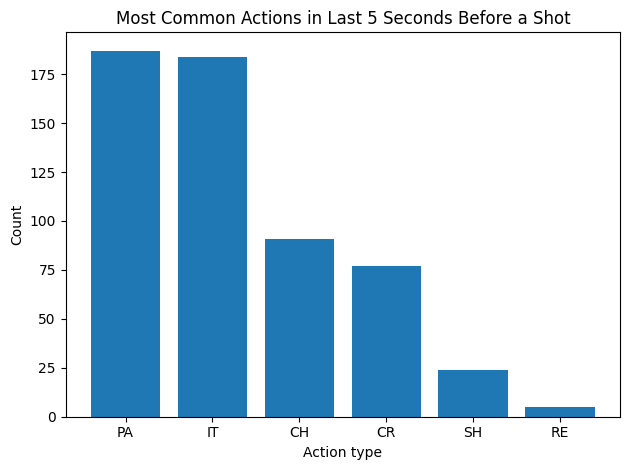

In [45]:
import matplotlib.pyplot as plt

top_actions = pre_shot_counts.head(6)

plt.figure()
plt.bar(top_actions.index.astype(str), top_actions.values)
plt.title("Most Common Actions in Last 5 Seconds Before a Shot")
plt.xlabel("Action type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Across multiple matches, pre-shot sequences are short and dominated by passes, initial touches, and crosses, indicating that shot creation often occurs within a brief, concentrated buildup window.